# 方法1: pybaseball spraychart() でフィールドを描く

**最もシンプルな方法** - pybaseballの組み込み関数を使用

| メリット | デメリット |
|----------|------------|
| コード最小限 | ヒートマップとの組み合わせに工夫が必要 |
| 30球団の球場形状を内蔵 | カスタマイズに制限 |
| 座標変換が自動 | |

---

In [1]:
!pip install pybaseball duckdb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.8 MB/s eta 0:00:00


In [2]:
from pybaseball import statcast, spraychart
import duckdb

## 1. データ取得

In [ ]:
# ====== 設定 ======
BATTER_ID = 660271      # 大谷翔平 MLBAM ID
SEASON_YEAR = 2025
GAME_TYPE = "R"         # "R"=レギュラーシーズン, "P"=ポストシーズン, None=全試合
# ==================

# Statcastデータ取得
df_raw = statcast(start_dt=f'{SEASON_YEAR}-03-01', end_dt=f'{SEASON_YEAR}-12-31')
print(f"Total records (raw): {len(df_raw):,}")

# game_typeでフィルタ
con = duckdb.connect()
if GAME_TYPE:
    df = con.execute(f"""
        SELECT * FROM df_raw WHERE game_type = '{GAME_TYPE}'
    """).df()
    print(f"Filtered records (game_type='{GAME_TYPE}'): {len(df):,}")
else:
    df = df_raw.copy()
    print(f"Using all game types: {len(df):,}")

In [4]:
# DuckDB で大谷のデータを抽出
df_hits = con.execute("""
    SELECT * FROM df
    WHERE batter = 660271
      AND events IN ('home_run', 'double', 'triple', 'single')
      AND hc_x IS NOT NULL AND hc_y IS NOT NULL
""").df()

df_all = con.execute("""
    SELECT * FROM df
    WHERE batter = 660271
      AND hc_x IS NOT NULL AND hc_y IS NOT NULL
""").df()

df_hr = con.execute("""
    SELECT * FROM df
    WHERE batter = 660271
      AND events = 'home_run'
      AND hc_x IS NOT NULL AND hc_y IS NOT NULL
""").df()

print(f"Hits: {len(df_hits)}, All: {len(df_all)}, HR: {len(df_hr)}")

Hits: 172, All: 426, HR: 55


## 2. spraychart() の基本的な使い方

```python
spraychart(data, team_stadium, title='', colorby='events')
```

| パラメータ | 説明 |
|------------|------|
| `data` | hc_x, hc_y, events列を含むDataFrame |
| `team_stadium` | `'angels'`, `'dodgers'`, `'generic'` など |
| `colorby` | `'events'` でイベント別に色分け |

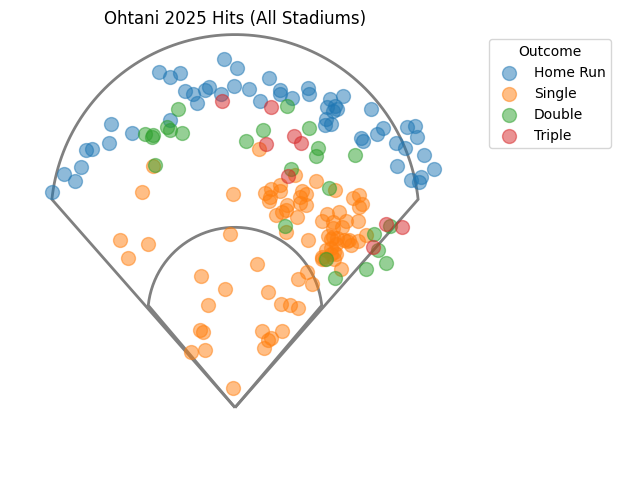

<Axes: title={'center': 'Ohtani 2025 Hits (All Stadiums)'}>

In [5]:
# 汎用スタジアム + イベント別色分け（全データ）
spraychart(df_hits, 'generic', title='Ohtani 2025 Hits (All Stadiums)', colorby='events')

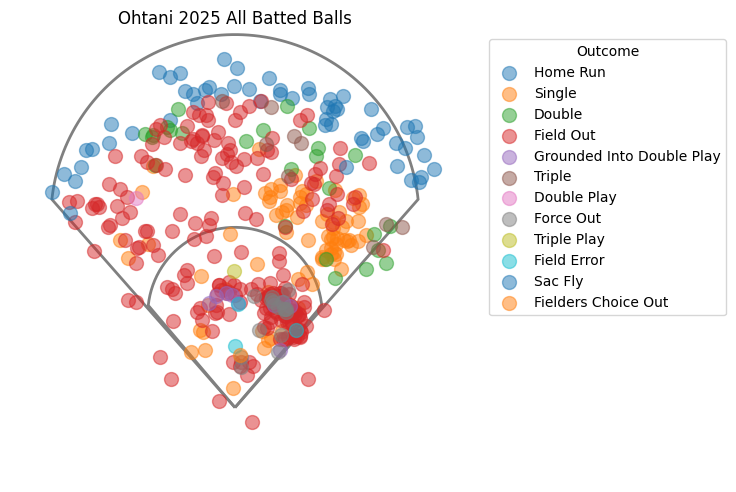

<Axes: title={'center': 'Ohtani 2025 All Batted Balls'}>

In [6]:
# 全打球
spraychart(df_all, 'generic', title='Ohtani 2025 All Batted Balls', colorby='events')

---
## 3. 球場別スプレーチャート（正しいフィルター方法）

**重要**: 球場別に表示する場合は、その球場でプレイしたデータのみを使用する

- `home_team` 列でフィルター
- 例: エンゼルスのホームゲーム → `home_team = 'LAA'`

**注意**: 球場の形だけ変えて全データを使うのは誤り！

In [7]:
# 球場 → チームコードのマッピング
STADIUM_TEAMS = {
    'angels': 'LAA', 'dodgers': 'LAD', 'yankees': 'NYY', 'red_sox': 'BOS',
    'astros': 'HOU', 'mariners': 'SEA', 'athletics': 'OAK', 'rangers': 'TEX',
    'padres': 'SD', 'giants': 'SF', 'cubs': 'CHC', 'white_sox': 'CWS',
    'twins': 'MIN', 'tigers': 'DET', 'royals': 'KC', 'guardians': 'CLE',
    'rays': 'TB', 'orioles': 'BAL', 'blue_jays': 'TOR', 'mets': 'NYM',
    'phillies': 'PHI', 'nationals': 'WSH', 'marlins': 'MIA', 'braves': 'ATL',
    'reds': 'CIN', 'brewers': 'MIL', 'cardinals': 'STL', 'pirates': 'PIT',
    'rockies': 'COL', 'diamondbacks': 'AZ'
}

def spraychart_by_stadium(df_data, stadium_name, con):
    """指定した球場でプレイしたデータのみをフィルターして表示"""
    team_code = STADIUM_TEAMS.get(stadium_name)
    if not team_code:
        print(f"Unknown stadium: {stadium_name}")
        return

    df_stadium = con.execute(f"""
        SELECT * FROM df_data WHERE home_team = '{team_code}'
    """).df()

    if len(df_stadium) == 0:
        print(f"No data at {stadium_name} ({team_code})")
        return

    print(f"{stadium_name.upper()} ({team_code}): {len(df_stadium)} batted balls")
    spraychart(df_stadium, stadium_name,
               title=f'Ohtani 2025 @ {stadium_name.title()} ({len(df_stadium)} balls)',
               colorby='events')

In [8]:
# 各球場でのデータ件数を確認
stadium_counts = con.execute("""
    SELECT home_team, COUNT(*) as balls, SUM(CASE WHEN events = 'home_run' THEN 1 ELSE 0 END) as HR
    FROM df_all
    GROUP BY home_team
    ORDER BY balls DESC
""").df()

print("=== Batted Balls by Stadium ===")
print(stadium_counts.to_string(index=False))

=== Batted Balls by Stadium ===
home_team  balls   HR
      LAD    220 29.0
       AZ     24  3.0
       SF     19  2.0
      COL     19  3.0
       SD     17  1.0
      STL     12  0.0
      CHC     12  1.0
      PIT      9  1.0
      WSH      9  1.0
      BAL      8  2.0
      CIN      8  0.0
      NYM      8  1.0
      MIA      7  2.0
      ATL      7  1.0
      LAA      6  2.0
      PHI      6  0.0
      BOS      6  1.0
      MIL      6  1.0
       KC      6  1.0
      SEA      5  1.0
       TB      5  0.0
      CLE      5  2.0
      TEX      2  0.0


DODGERS (LAD): 220 batted balls


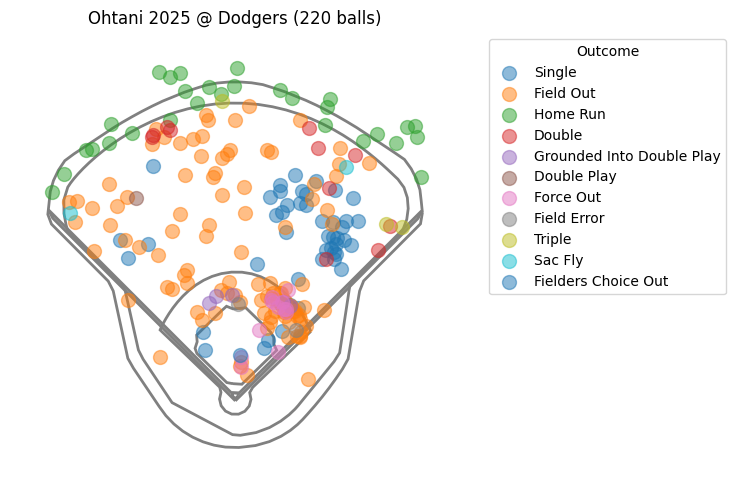

In [9]:
# ドジャースタジアム（ホーム）
spraychart_by_stadium(df_all, 'dodgers', con)

PADRES (SD): 17 batted balls


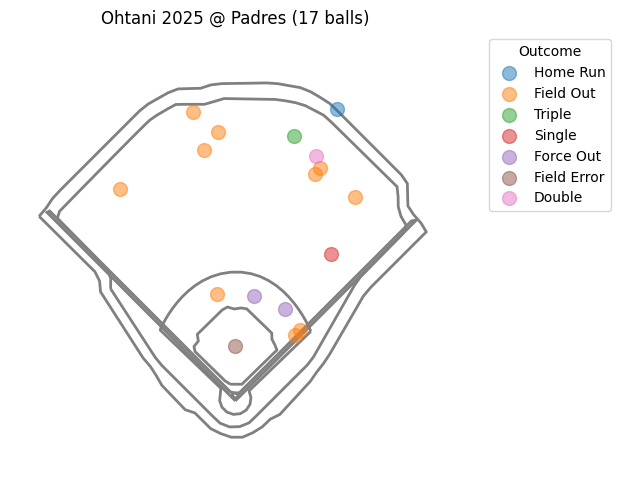

In [10]:
# パドレス（アウェイ・同地区）
spraychart_by_stadium(df_all, 'padres', con)

GIANTS (SF): 19 batted balls


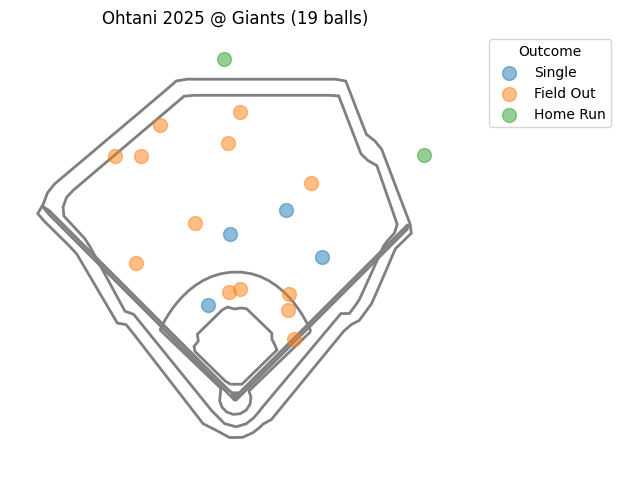

In [11]:
# ジャイアンツ（アウェイ・同地区）
spraychart_by_stadium(df_all, 'giants', con)

---
## 4. ホームラン専用

In [12]:
# HR球場別
hr_by_stadium = con.execute("""
    SELECT home_team, COUNT(*) as HR FROM df_hr GROUP BY home_team ORDER BY HR DESC
""").df()
print("=== Home Runs by Stadium ===")
print(hr_by_stadium.to_string(index=False))

=== Home Runs by Stadium ===
home_team  HR
      LAD  29
       AZ   3
      COL   3
      CLE   2
       SF   2
      BAL   2
      LAA   2
      MIA   2
      PIT   1
       SD   1
      BOS   1
      SEA   1
      MIL   1
       KC   1
      NYM   1
      ATL   1
      WSH   1
      CHC   1


HR at Dodger Stadium: 29


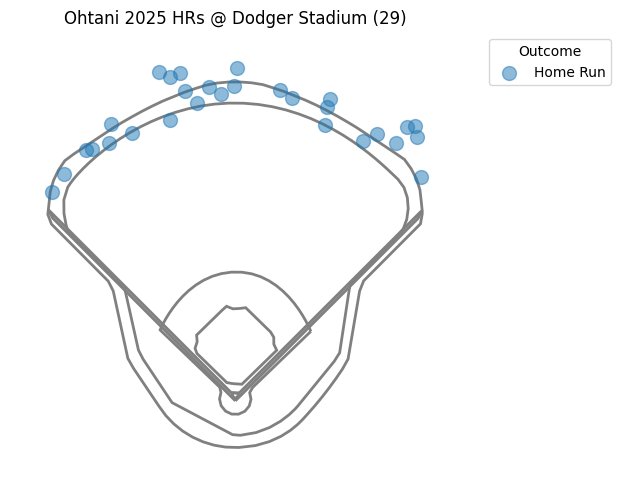

In [13]:
# ドジャースタジアムでのホームラン
df_hr_dodgers = con.execute("SELECT * FROM df_hr WHERE home_team = 'LAD'").df()
if len(df_hr_dodgers) > 0:
    print(f"HR at Dodger Stadium: {len(df_hr_dodgers)}")
    spraychart(df_hr_dodgers, 'dodgers', title=f'Ohtani 2025 HRs @ Dodger Stadium ({len(df_hr_dodgers)})')

---
## まとめ

**pybaseball spraychart() のポイント:**

1. **最もシンプル** - 1行でフィールド描画
2. **30球団の球場形状を内蔵** - `'angels'`, `'dodgers'`, `'generic'` など
3. **球場別は必ず `home_team` でフィルター** - 形だけ変えてもデータは変わらない

```python
# 基本
spraychart(df, 'generic', title='Title', colorby='events')

# 球場別（正しい方法）
df_stadium = df[df['home_team'] == 'LAA']
spraychart(df_stadium, 'angels', title='@ Angel Stadium')
```